# Diffusion Models

- Diffusion models work by gradually adding noise to data and then learning to reverse this process.
- They consist of two main processes:
    - Forward diffusion (adding noise gradually)
    - Reverse diffusion (removing noise gradually)


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

2025-04-28 06:34:58.597848: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 06:34:58.612887: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 06:34:58.751563: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 06:34:58.866344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745822098.956955     809 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745822098.98

### 1. Noise Schedule

```python
self.beta = tf.linspace(beta_start, beta_end, time_steps)
self.alpha = 1 - self.beta
self.alpha_bar = tf.math.cumprod(self.alpha)
```

- Controls how noise is added during forward diffusion
- Beta increases linearly from beta_start to beta_end
- Alpha and Alpha_bar are used to calcualte noise levels


In [2]:
beta_start = 2
beta_end = 20
time_steps = 10

beta = tf.linspace(beta_start, beta_end, time_steps)
alpha = 1 - beta

# This is cumulative product (2 * 4 * 8 * 10)
alpha_bar = tf.math.cumprod(beta)

print(f"Beta is {beta} \n alpha is {alpha} \n alpha bar is {alpha_bar}")

Beta is [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20.] 
 alpha is [ -1.  -3.  -5.  -7.  -9. -11. -13. -15. -17. -19.] 
 alpha bar is [2.0000000e+00 8.0000000e+00 4.8000000e+01 3.8400000e+02 3.8400000e+03
 4.6080000e+04 6.4512000e+05 1.0321920e+07 1.8579456e+08 3.7158912e+09]


2025-04-28 06:36:17.871512: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### 2. Forward Diffusion

- Gradually adds noise to the input data
- The amount of noise depends on the timestep t

In [22]:
t = 3

# Add noise according to the noise schedule
alpha_t = tf.gather(alpha_bar, t)
print(f"alpha t is {alpha_t}")

alpha t is 384.0


In [18]:
alpha_t = tf.reshape(alpha_t, (-1, 1, 1, 1))
print(f"alpha t becomes {alpha_t}")

alpha t becomes [[[[384.]]]]


In [19]:
noise = tf.random.normal(shape=x_0.shape)
print(noise)
# return tf.sqrt(alpha_t) * x_0 + tf.sqrt(1 - alpha_t) * noise, noise

NameError: name 'x_0' is not defined

In [23]:


class DiffusionModel(tf.keras.Model):
    def __init__(self, time_steps=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()

        #Define noise schedule
        self.time_steps = time_steps
        self.beta = tf.linspace(beta_start, beta_end, time_steps)
        self.alpha = 1 - self.beta
        self.alpha_bar = tf.math.cumprod(self.alpha)

        # Define the U-Net architecture for noise prediction
        self.model = self.build_unet()

    def build_unet(self):
        # Simple U-Net architecture
        inputs = tf.keras.Input(shape=(28, 28, 1))
        x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
        x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(1, 3, padding='same')(x)
        return tf.keras.Model(inputs=inputs, outputs=x)
    
    def forward_diffusion(self, x_0, t):
        # Add noise according to the noise schedule
        alpha_t = tf.gather(self.alpha_bar, t)
        alpha_t = tf.reshape(alpha_t, (-1, 1, 1, 1))
        
        noise = tf.random.normal(shape=x_0.shape)
        return tf.sqrt(alpha_t) * x_0 + tf.sqrt(1 - alpha_t) * noise, noise
    
    def train_step(self, x_0):
        # Sample random timesteps
        t = tf.random.uniform(
            shape=(tf.shape(x_0)[0],),
            minval=0,
            maxval=self.time_steps,
            dtype=tf.int32
        )
        
        with tf.GradientTape() as tape:
            # Forward diffusion
            x_noisy, noise = self.forward_diffusion(x_0, t)
            
            # Predict noise
            predicted_noise = self.model(x_noisy, training=True)
            
            # Calculate loss
            loss = tf.reduce_mean(tf.square(noise - predicted_noise))
        
        # Update model parameters
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        return {'loss': loss}

    def sample(self, n_samples):
        # Start from random noise
        x = tf.random.normal(shape=(n_samples, 28, 28, 1))
        
        # Gradually denoise
        for t in range(self.time_steps - 1, -1, -1):
            t_tensor = tf.constant([t], dtype=tf.int32)
            t_tensor = tf.repeat(t_tensor, n_samples)
            
            # Predict noise
            predicted_noise = self.model(x)
            
            alpha_t = tf.gather(self.alpha, t)
            alpha_bar_t = tf.gather(self.alpha_bar, t)
            
            # Update sample
            if t > 0:
                noise = tf.random.normal(shape=x.shape)
            else:
                noise = 0
                
            x = (1 / tf.sqrt(alpha_t)) * (
                x - (1 - alpha_t) / tf.sqrt(1 - alpha_bar_t) * predicted_noise
            ) + tf.sqrt(self.beta[t]) * noise
            
        return x



## Training

Training data sample
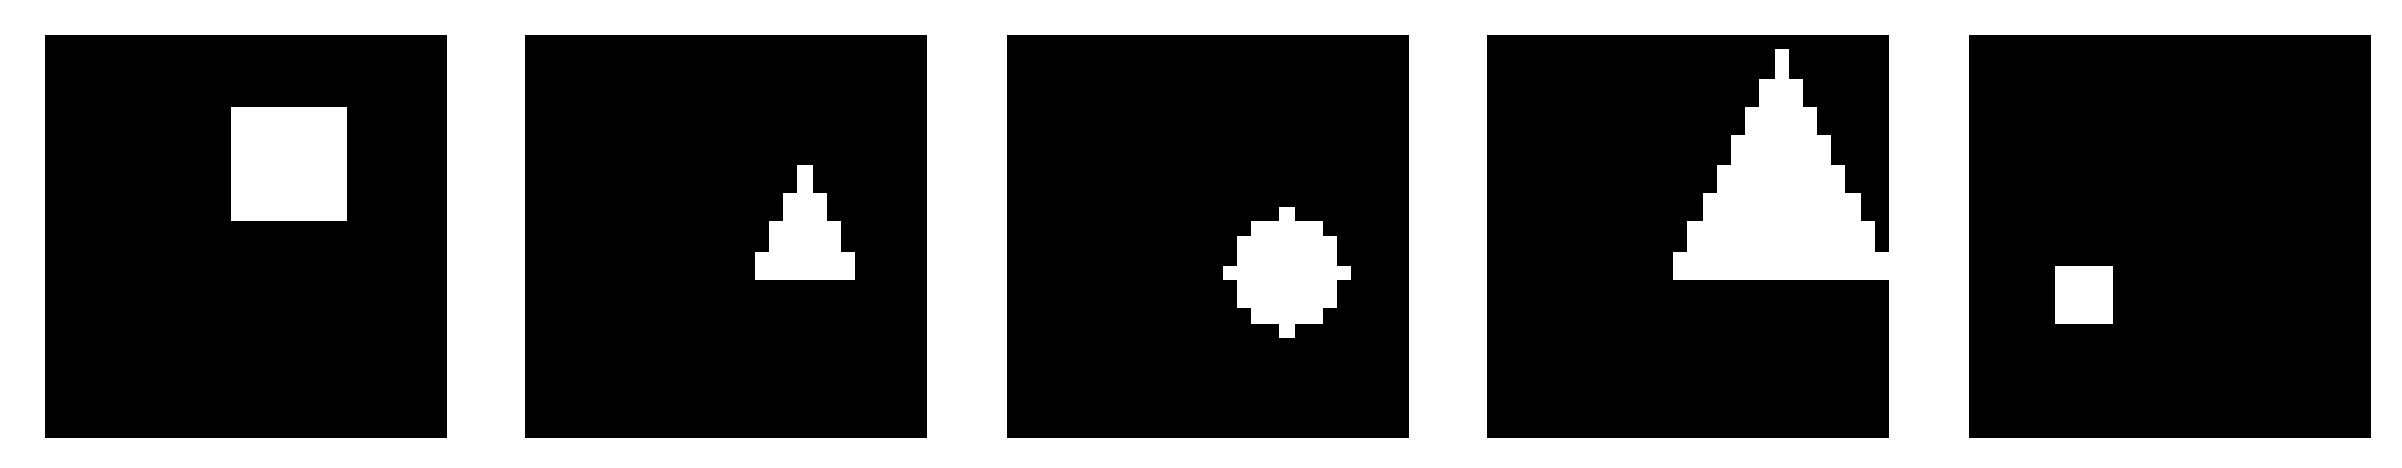

In [25]:
from shapes_dataset import create_shape_dataset

dataset = create_shape_dataset()

In [26]:
# Now you can train the diffusion model
diffusion = DiffusionModel()
diffusion.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [27]:
# Train the model
history = diffusion.fit(dataset, epochs=1)

ValueError: Cannot convert a partially known TensorShape (None, 28, 28, 1) to a Tensor.

## Generate Samples

In [ ]:
# Generate and visualize samples
generated_samples = diffusion.sample(n_samples=5)

# Visualize generated samples
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_samples[i].numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Initialize the model
diffusion = DiffusionModel()

# Compile the model
diffusion.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# Train the model (assuming you have a dataset)
diffusion.fit(dataset, epochs=100)

# Generate new samples
samples = diffusion.sample(n_samples=16)
